Image dtype: uint8
Original transform: | 0.05, 0.00, 419820.70|
| 0.00,-0.05, 4638991.50|
| 0.00, 0.00, 1.00|


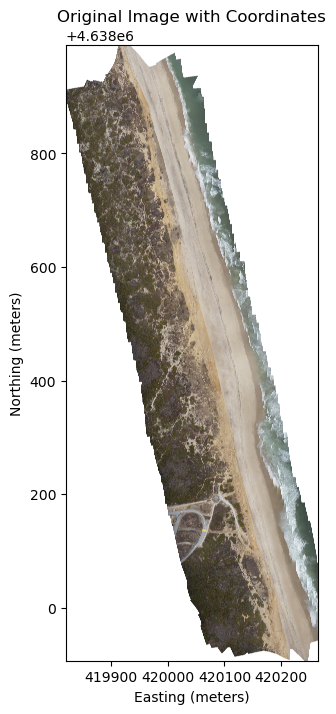

New transform: | 0.05, 0.02,-772046.12|
| 0.02,-0.05, 9141133.22|
| 0.00, 0.00, 1.00|


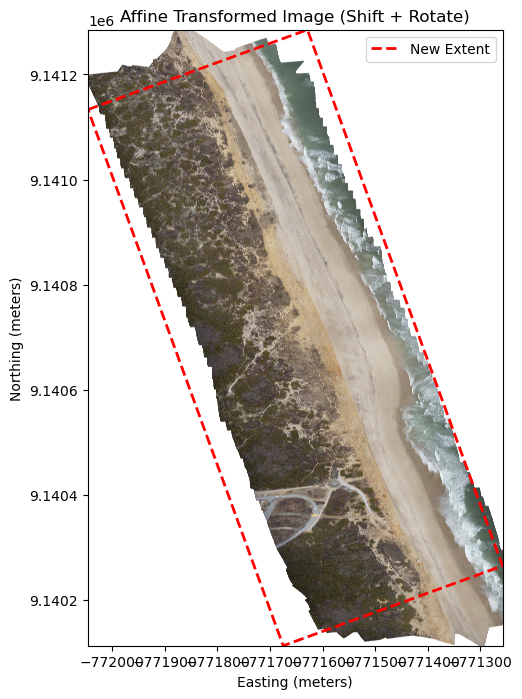

In [13]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import Affine

# Load the image
data_dir = 'F:/crs/proj/2025_Marconi_maps/Marconi_Products/'
fn = "2025-005-FA_Mar_Marconi_YSMP_SfM_Ortho_Full_5cm.tif"
with rasterio.open(data_dir + fn) as src:
    img = src.read()  # Read all bands
    transform = src.transform

print("Image dtype:", img.dtype)
print("Original transform:", transform)

# Convert to RGB (first 3 bands)
rgb_image = np.transpose(img[:3], (1, 2, 0))

# Extract original coordinates from transform
xres, yres = transform.a, -transform.e  # Pixel resolution
xmin, ymax = transform.c, transform.f  # Upper-left corner

# Generate coordinate grids
height, width = rgb_image.shape[:2]
x_coords = np.linspace(xmin, xmin + width * xres, width)
y_coords = np.linspace(ymax, ymax - height * yres, height)

# Plot original image with coordinate axes
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(rgb_image, extent=[x_coords[0], x_coords[-1], y_coords[-1], y_coords[0]])
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
ax.set_title("Original Image with Coordinates")
plt.show()

# -------------------------------------------------------
# **Step 2: Apply Affine Transformation (Translation + Rotation)**
# -------------------------------------------------------
# actual camera location 420087.173	4638326.089

utmeast0, utmnorth0 =420080., 4638320.  # New UTM origin

# Define rotation matrix for 20° CCW
theta = np.radians(20)
cos_theta, sin_theta = np.cos(theta), np.sin(theta)

rotation = Affine(cos_theta, -sin_theta, 0,
                  sin_theta, cos_theta, 0)

# Define translation to the new origin
translation = Affine(1, 0, utmeast0,
                     0, 1, utmnorth0)

# Compute the final transformation matrix
new_transform = translation * rotation * transform  # Correct order

print("New transform:", new_transform)

# Compute transformed extent (bounding box)
x0, y0 = new_transform * (0, 0)
x1, y1 = new_transform * (width, 0)
x2, y2 = new_transform * (width, height)
x3, y3 = new_transform * (0, height)

x_coords_new = [x0, x1, x2, x3, x0]  # Closing polygon
y_coords_new = [y0, y1, y2, y3, y0]

# Plot transformed image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(rgb_image, extent=[min(x_coords_new), max(x_coords_new), min(y_coords_new), max(y_coords_new)])
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
ax.set_title("Affine Transformed Image (Shift + Rotate)")

# Overlay bounding box
ax.plot(x_coords_new, y_coords_new, color='red', linestyle='--', linewidth=2, label="New Extent")
ax.legend()
plt.show()

